# Action Log Analysis



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

#retweet = "RT"
#mention = "MT"
#reply = "RE"

In [2]:
"""Read action log into a pandas dataframe"""

def dateparse (timestamp):    
    return datetime.datetime.fromtimestamp(float(timestamp))

log = pd.read_csv("./Data/higgs-activity_time.txt", delimiter=" ",
                  index_col="time", parse_dates=True, date_parser=dateparse)

print(log.shape[0])
log = log.loc[log["type"] != "RE"]
print(log.shape[0])
users = log["user2"].drop_duplicates()

#threshold = 5
#value_counts = log["user2"].value_counts()
##print(value_counts.head())
#to_remove = value_counts[value_counts <= threshold].index
#print("will remove: {}".format(len(to_remove)))
#print(to_remove[0])
#log = log.drop(to_remove)
#
#print(log.shape[0])
#        
print(log.head())


563069
526167
                      user1   user2 type
time                                    
2012-06-30 17:02:52  223789  213163   MT
2012-06-30 17:06:21  376989   50329   RT
2012-06-30 17:06:23   26375  168366   MT
2012-06-30 17:06:32  376989   13813   RT
2012-06-30 17:06:48  453850       8   RT


In [3]:
"""Split a dataset into n unequal time intervals"""

def split_dataset(df, n, tmin, timedeltas):
    """df must have date index, and timedeltas must stay in range"""
    
    splits = []
    
    _min = tmin
    _max = tmin + timedeltas[0]
    
    for i in range(1,n):
        split = df.truncate(before=_min, after=_max)
        splits.append(split)
        _min = _max
        _max = _max + timedeltas[i]
    
    split = df.truncate(before=_min, after=_max)
    splits.append(split)
        
    return splits

# Split dataset into periods I, II, III, IV 
num_periods = 4
tmin = log.index.min()
tmax = log.index.max()
timedeltas = [datetime.timedelta(days=0.733),
                datetime.timedelta(days=1.56),
                datetime.timedelta(days=1.8),
                datetime.timedelta(days=3.733)]
splits = split_dataset(log, num_periods, tmin, timedeltas)

for i in range(num_periods):
    print("Split {} has {} actions".format(i, splits[i].shape[0]))
    print(splits[i].index.min(), splits[i].index.max())

print(log.tail())

Split 0 has 1617 actions
2012-06-30 17:02:52 2012-07-01 10:38:11
Split 1 has 23132 actions
2012-07-01 10:38:48 2012-07-03 00:04:41
Split 2 has 370195 actions
2012-07-03 00:04:50 2012-07-04 19:16:45
Split 3 has 131223 actions
2012-07-04 19:16:49 2012-07-07 16:59:53
                      user1  user2 type
time                                   
2012-07-07 16:58:50   97296  15483   MT
2012-07-07 16:59:12   19979  49694   MT
2012-07-07 16:59:12   19979  80429   MT
2012-07-07 16:59:34  178085   1062   RT
2012-07-07 16:59:53   23996    253   RT


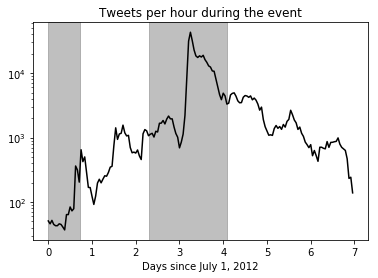

In [4]:
"""Make plot of tweets/hour"""

import matplotlib.dates as mdates

tmin = log.index.min()
tmax = log.index.max()

N = 167.9191
dt = (tmax - tmin) / N #makes the deltas equal an hour

T = []
t = tmin
tweets_per_hour = []
while t < tmax:
    tweets_per_hour.append(log[t:t+dt].shape[0])
    T.append(t)
    t += dt
T = mdates.date2num(T); T = T - T[0]

s1 = 0.733
s2 = 1.56 + s1
s3 = 1.8 + s2
s4 = 3.733 + s3

(fig, ax) = plt.subplots()
ax.semilogy(T, tweets_per_hour, color="k")
ax.axvspan(0, s1, alpha=0.5, color='grey')
ax.axvspan(s2, s3, alpha=0.5, color='grey')
plt.title("Tweets per hour during the event")
plt.xlabel("Days since July 1, 2012")
plt.xticks(np.arange(8))
plt.show()



## Table 1: activities / period
| Period | #activities |
| ------------- |:-------------:|
| I      | 1617        |
| II     | 23132       |
| III    | 370195      |
| IV     | 131223      |


In [5]:
# Count occurences of users as (mentioned, retweeted, replied)

#print(log.shape[0])

users = log["user2"].drop_duplicates()
#print(users.shape[0])

counts = np.zeros((users.shape[0], num_periods), dtype=np.uint32)
user_index = np.zeros(users.shape[0], dtype=np.uint32)

first = True
for i in range(num_periods):
    print(i)
    split = splits[i]
    j = 0
    for user in users:
        if first:
            user_index[j] = user
        counts[j][i] = (split[split["user2"] == user]).shape[0]
        j += 1
    first = not first
        

0
1
2
3


In [6]:
print(counts[0:10, :])
print(user_index[0:10])

[[   2    0    2    0]
 [   4    5   26   15]
 [   1    0    0    0]
 [   5    5 1827   63]
 [  20  306  920   17]
 [   1    1    1    0]
 [   1    0    0    0]
 [   1    0    5    7]
 [   6   19    9    5]
 [   2   11  353   31]]
[213163  50329 168366  13813      8 364376 364375  60337  84647  42182]


In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

data = counts
#scaler = StandardScaler().fit(data)
#centered = scaler.transform(data)

num_clusters = 4

pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit(reduced_data)
print("fitted")


fitted


30.9018181845
2.14708924044


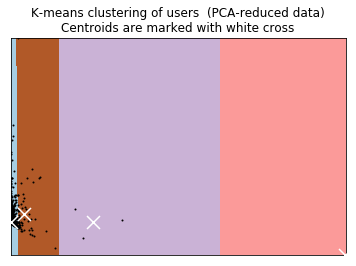

In [8]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 1000     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

print((x_max - x_min) / h)
print((y_max - y_min) / h)

xx, yy = np.meshgrid(np.linspace(x_min, x_max, h), np.linspace(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering of users  (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

[[  1.47716060e-02   2.99628027e-01   4.00219204e+00   1.89286661e+00]
 [  1.75490229e+02   1.17832405e+03   3.07676606e+04   2.61449303e+03]
 [  4.30691063e+01   2.92327432e+02   7.57561259e+03   7.23247011e+02]
 [  6.57484740e+00   4.81011972e+01   1.18364894e+03   2.00629433e+02]]
59908 users in cluster 0
1 users in cluster 1
88
3 users in cluster 2
65 users in cluster 3


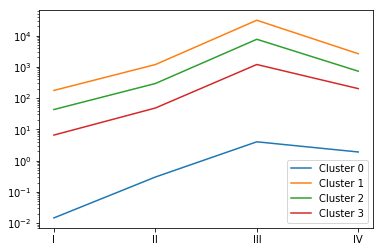

In [9]:
"""Describe clustering results"""

centroids = kmeans.cluster_centers_
i_centroids = pca.inverse_transform(centroids)
print(i_centroids)
#i_centroids = scaler.inverse_transform(i_centroids)
#print(i_centroids)

# Print centroids
for i in range(num_clusters):
    (c,) = np.where(kmeans.labels_ == i)
    num_in_cluster = len(c)
    print("{} users in cluster {}".format(num_in_cluster, i))
    if i == 1:
        print(user_index[c[0]])

# Plot centroids along time-axis
plt.figure(2)
handles = []
P = range(num_periods)
for i in range(num_clusters):
    h, = plt.semilogy(P, i_centroids[i,:], label="Cluster {}".format(i))
    handles.append(h)

plt.legend(handles=handles)
plt.xticks(P, ["I", "II", "III", "IV"])
plt.show()

In [10]:
"""Find a unique (cluster 1) user"""

averages = [0]*num_clusters

for i in range(1,num_clusters):

    users_in_cluster = user_index[np.where(kmeans.labels_ == i)]
    avg = 0.0
    for user in users_in_cluster:
        avg += (log[log["user2"] == user]).shape[0]
    avg /= len(users_in_cluster)
    averages[i] = avg
    
print(averages)

[0, 34664.0, 8695.0, 1449.0461538461539]
